In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt

from WADParser import open_wad_file
from WADViewer import WadViewer
from WADPlayer import MIDIPlayer
from mus2mid import Mus2Mid

In [3]:
w = open_wad_file('WADs/DOOM2.WAD')

2025-04-07 14:28:14.488 | INFO     | WADParser:__init__:41 - Found a DOOM IWAD.
2025-04-07 14:28:14.492 | INFO     | WADParser:_get_palette:116 - Palette extracted.
2025-04-07 14:28:14.503 | INFO     | WADParser:_parse_levels:156 - Found 32 level(s) in this WAD.
2025-04-07 14:28:14.511 | INFO     | WADParser:_parse_things:128 - DOOM THINGS loaded.
2025-04-07 14:28:14.634 | INFO     | WADParser:_parse_by_markers:186 - Found 147 FLATS in this WAD.
2025-04-07 14:28:14.634 | INFO     | WADParser:_parse_by_markers:186 - Found 1381 SPRITES in this WAD.
2025-04-07 14:28:14.710 | INFO     | WADParser:_gather_textures:325 - Found 427 textures in 1 texture lumps.
2025-04-07 14:28:14.713 | INFO     | WADParser:_gather_musics:337 - Found 35 music lumps.


In [4]:
viewer = WadViewer(w)

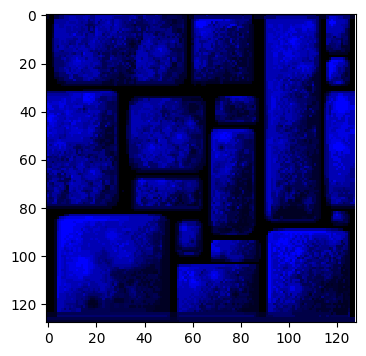

In [47]:
texs = list(w.textures.keys())

fig, ax = plt.subplots(figsize=(4, 4))
viewer.draw_tex(texs[-10], ax=ax)

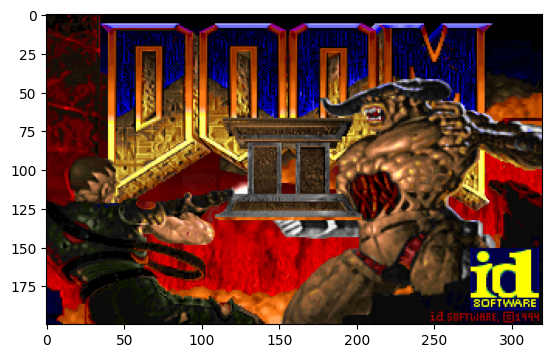

In [14]:
if 'TITLEPIC' in w.lump_names:
    idx = w.lump_names.index('TITLEPIC')
    _, offset, size = w.lumps[idx]
    rgb = viewer.draw_patch(offset, size)

shape = rgb.shape[:2]
plt.imshow(rgb / 255)

2025-04-07 14:28:26.796 | INFO     | WADViewer:draw_map:127 - Plotted map MAP02.


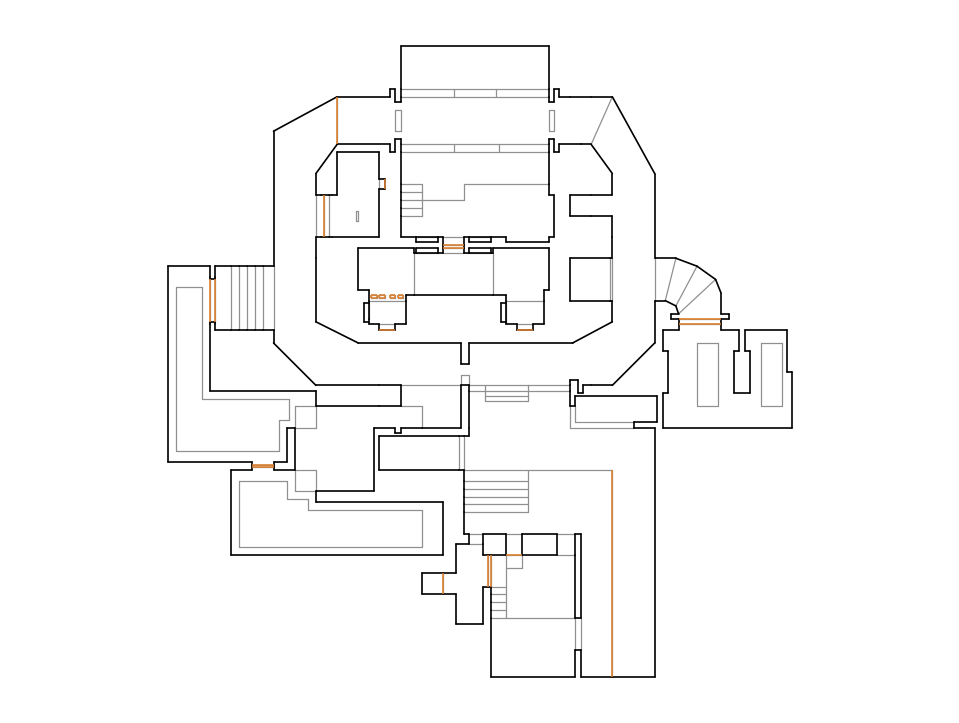

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)
viewer.draw_map('MAP02', palette='OMGIFOL', ax=ax)

In [7]:
mus_name = 'MUS_E1M1'
w.save_mus(mus_name)
m2m = Mus2Mid(f'output/{mus_name}.mus')
m2m.to_midi(f'output/{mus_name}.mid')


2025-04-04 23:36:48.556 | INFO     | WADParser:save_mus:351 - Saved music MUS_E1M1 to output/MUS_E1M1.mus.
2025-04-04 23:36:48.566 | INFO     | mus2mid:__init__:73 - File format detected: b'MUS\x1a'
2025-04-04 23:36:48.581 | INFO     | mus2mid:mus2mid:220 - Track size written: 22878 vs 15906
2025-04-04 23:36:48.581 | INFO     | mus2mid:to_midi:227 - Exported MUS output/MUS_E1M1.mus as a MIDI file to output/MUS_E1M1.mid.


In [ ]:
player = MIDIPlayer(f'output/{mus_name}.mid')
player.play()

2025-04-04 23:37:05.780 | INFO     | WADPlayer:play_midi:37 - Playing MIDI file: output/MUS_E1M1.mid


2025-04-04 23:37:34.086 | INFO     | WADPlayer:play_midi:46 - Stopped by user
2025-04-04 23:37:34.087 | INFO     | WADPlayer:stop_midi:59 - Stopping MIDI playback


In [10]:
player.stop()

AttributeError: 'NoneType' object has no attribute 'keys'

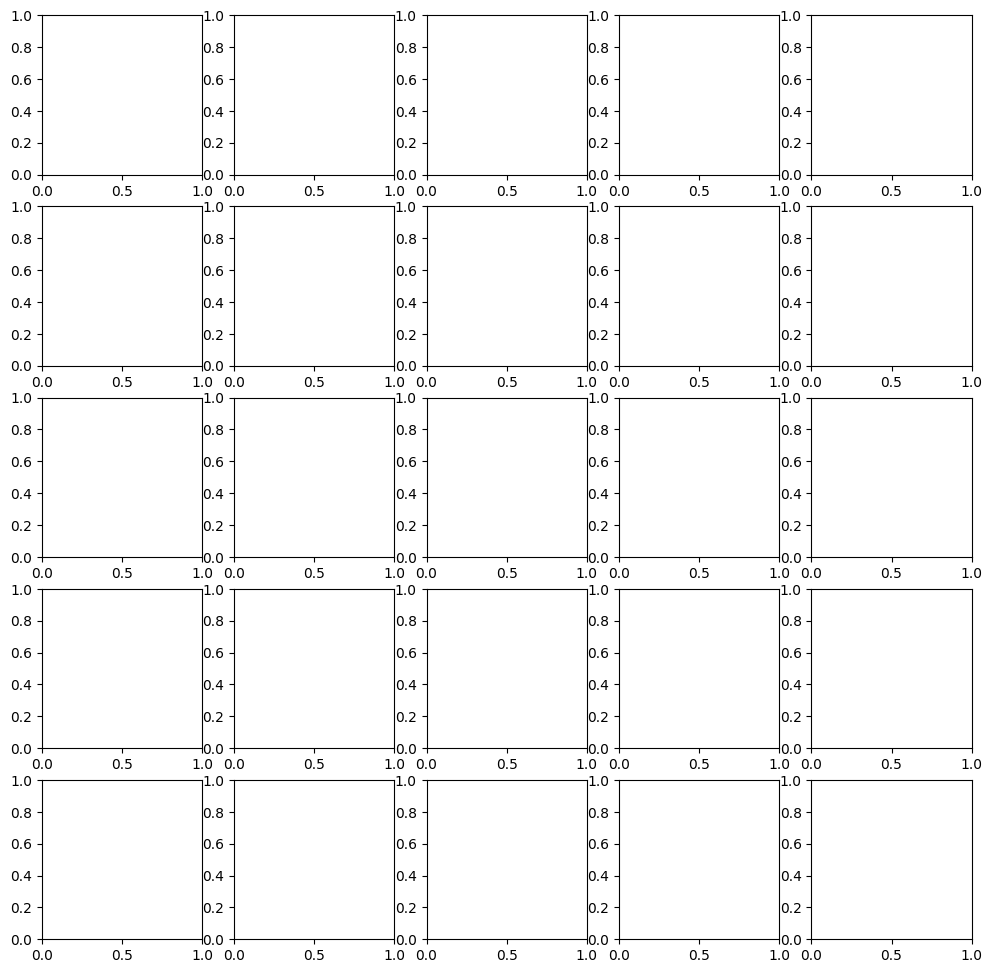

In [6]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    viewer.draw_flat(flat_name, ax=ax[i])
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

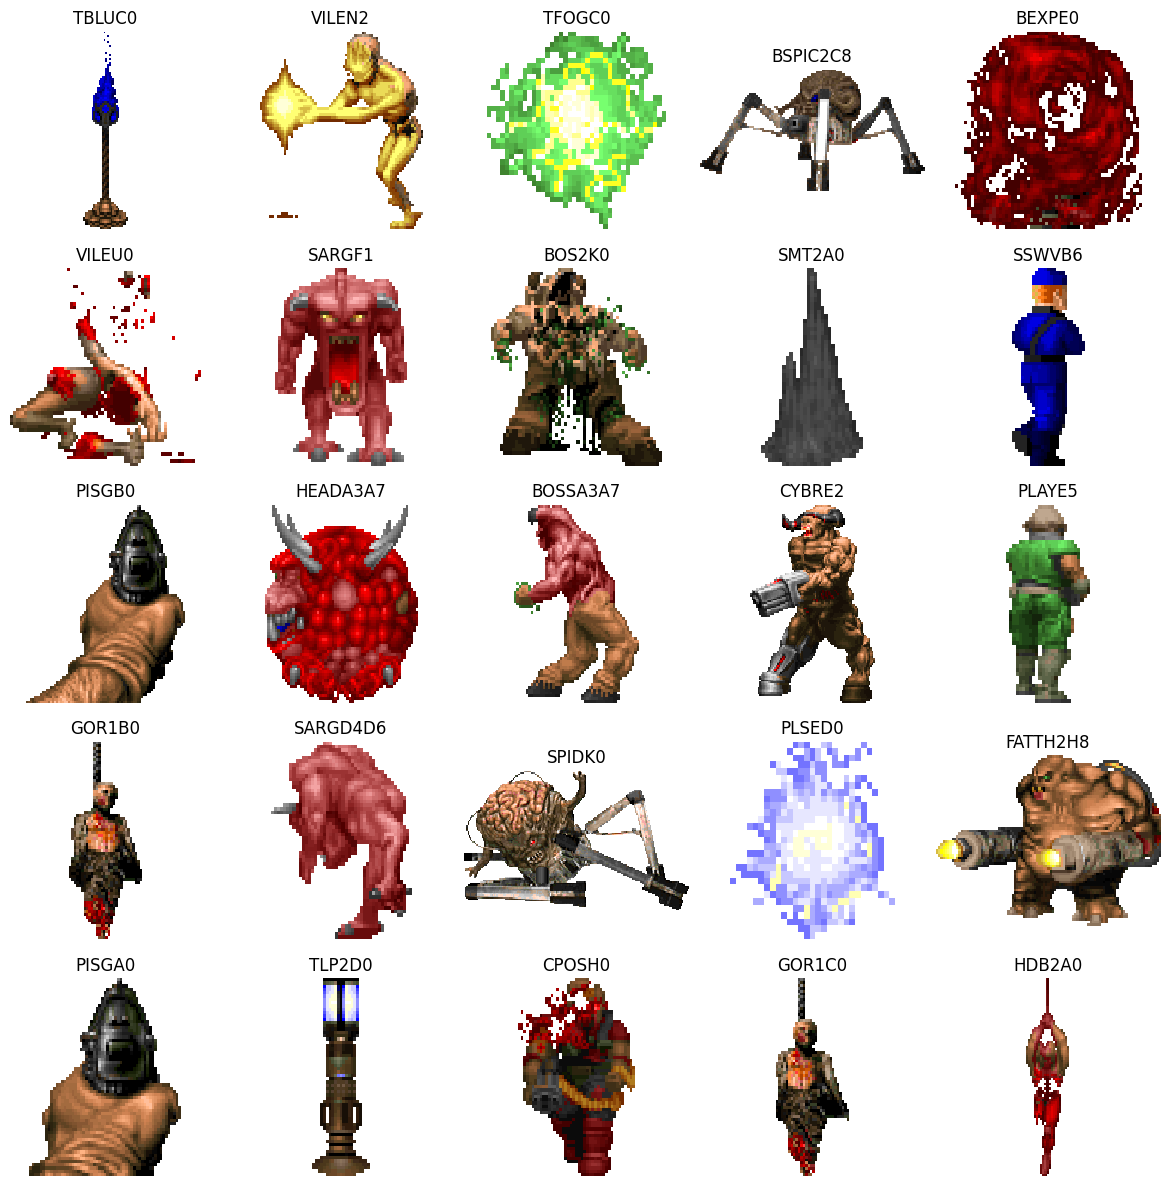

In [6]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

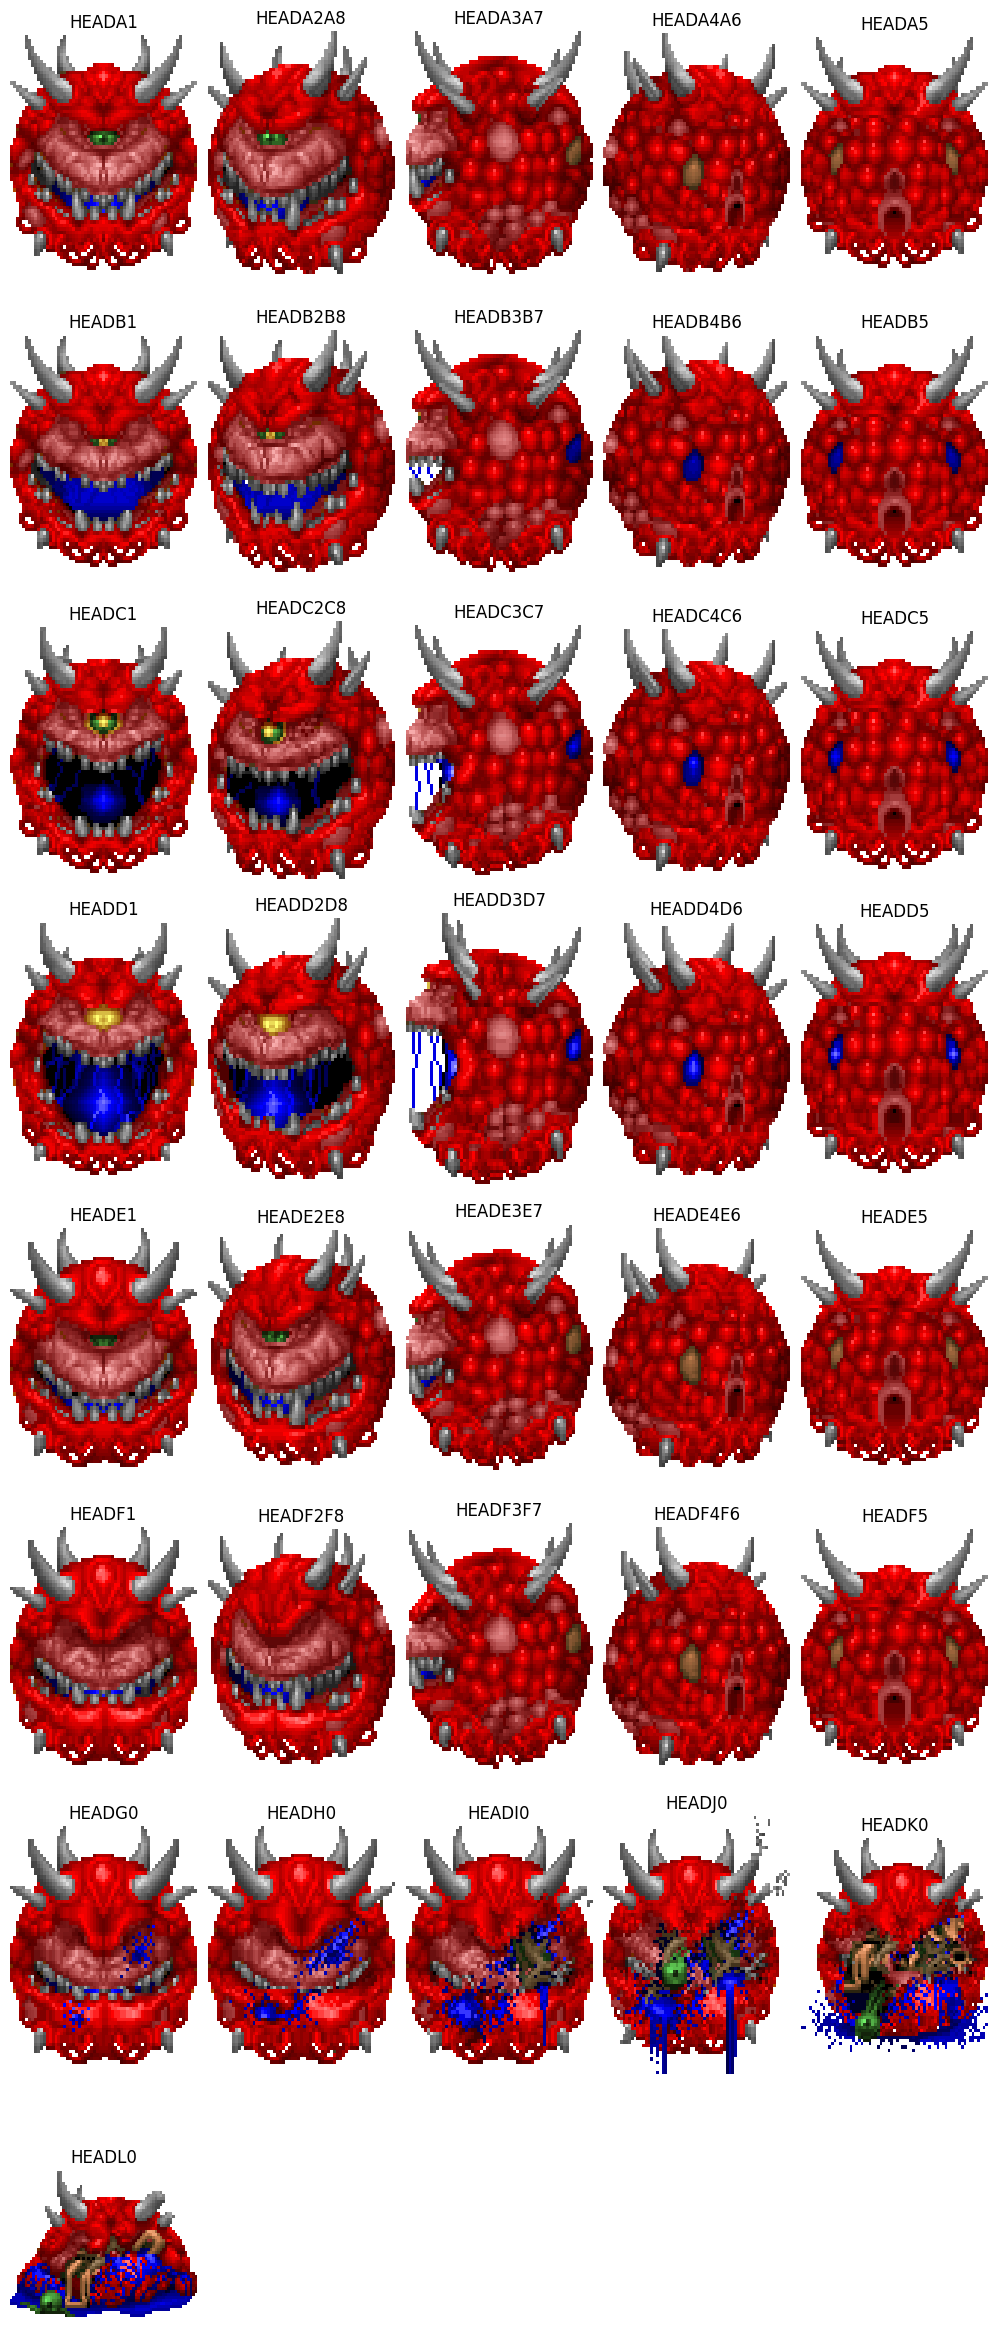

In [7]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)